# What does this Notebook do?
This notebook pre-processes the Qobs data from WSC HYDAT (https://www.canada.ca/en/environment-climate-change/services/water-overview/quantity/monitoring/survey/data-products-services/national-archive-hydat.html) for a specified river basin (both compiled by Shervan and found in GLOBALWATER).
It calculates Q volumes and quantiles from daily Q for a specified forecasting period.

In [1]:
import xarray as xr
import numpy as np
import datetime
from datetime import date
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import geopandas as gpd
import matplotlib.patches as mpatches

## Read selected basins

In [2]:
%store -r basinno
%store -r basins
%store -r randomcolors

display(basins)

,Station,StationNam,Stn_UID,Shp_Area,Shp_Perime,geometry,HydexArea
0,05BB001,BOW RIVER AT BANFF,05BB001_1,2209.593735,340.817572,"POLYGON Z ((-116.45854 51.72693 0.00000, -116....",NaN
1,08NG065,KOOTENAY RIVER AT FORT STEELE,08NG065_1,11469.599609,938.643005,"POLYGON Z ((-115.65527 49.61030 0.00000, -115....",None
2,08KB001,FRASER RIVER AT SHELLEY,08KB001_1,32436.599609,1968.160034,"POLYGON Z ((-122.61240 53.99059 0.00000, -122....",None
3,09CD001,YUKON RIVER ABOVE WHITE RIVER,09CD001_1,149347.229154,3246.830544,"POLYGON Z ((-139.85081 63.13083 0.00000, -139....",NaN
4,09DD003,STEWART RIVER AT THE MOUTH,09DD003_1,51023.181464,1945.439489,"POLYGON Z ((-136.56373 64.34605 0.00000, -136....",NaN
5,02GA041,GRAND RIVER NEAR DUNDALK,02GA041_1,66.500000,NaN,"POLYGON Z ((-80.33917 44.24417 0.00000, -80.33...",NaN
6,02OJ007,RICHELIEU (RIVIERE) AUX RAPIDES FRYERS,02OJ007_1,22000.000000,NaN,"POLYGON Z ((-73.27833 45.41333 0.00000, -73.26...",NaN
7,01AD004,SAINT JOHN RIVER AT EDMUNDSTON,01AD004_1,15500.000000,NaN,"POLYGON Z ((-69.25917 47.82333 0.00000, -69.25...",NaN
8,02LG005,GATINEAU (RIVIERE) AUX RAPIDES CEIZUR,02LG005_1,6840.000000,NaN,"POLYGON Z ((-75.42667 48.17250 0.00000, -75.42...",NaN


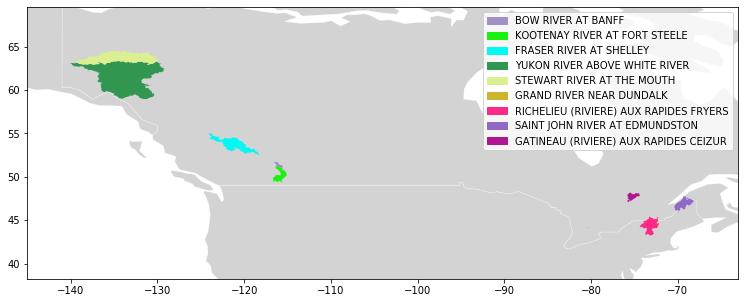

In [3]:
# Plot the selected basins
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(20,5), linewidth=0.25, edgecolor='white', color='lightgrey')
patches = []

for s in range(len(basinno)):
    basins.loc[basins['Station'] == basinno[s]].plot(ax=ax, facecolor=randomcolors[basinno[s]][0])
    patches += [mpatches.Patch(color=randomcolors[basinno[s]][0], label=basins.iloc[s].StationNam)]
minx, miny, maxx, maxy = min(basins.geometry.bounds.minx),min(basins.geometry.bounds.miny),max(basins.geometry.bounds.maxx),max(basins.geometry.bounds.maxy)
ax.set_xlim(minx - 5, maxx + 5)
ax.set_ylim(miny - 5, maxy + 5)
plt.legend(handles=patches);

## Read stations daily Q data

In [4]:
# Specify basins shapefiles directory and station numbers
qstationsdatafolder = "/Users/lla068/Desktop/statistical_forecasting/data/"

# Save stations daily Q data into one DataArray 
for s in range(len(basinno)):
    qstationdata = xr.open_dataset(qstationsdatafolder+"HYDAT_"+basinno[s][:2]+".nc")
    stationq_da = qstationdata.where(qstationdata.Station_ID==basinno[s], drop=True).Flow #because Station_ID not indexed
    if s == 0:
        stationsq_da = stationq_da
    else:
        stationsq_da = xr.concat([stationsq_da,stationq_da], 'n')
stationsq_da = stationsq_da.set_index({"Station_ID":"Station_ID"})
stationsq_da = stationsq_da.rename({"n":'Station_ID'})
stationsq_da = stationsq_da.assign_coords(Station_Name= ("Station_ID", basins.loc[basins['Station'] == basinno].StationNam.values))

display(stationsq_da)

<xarray.DataArray 'Flow' (Station_ID: 9, time: 62092)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * time          (time) datetime64[ns] 1850-01-01 1850-01-02 ... 2020-01-01
    lat           (Station_ID) float64 51.17 49.61 54.0 ... 45.4 47.36 47.08
    lon           (Station_ID) float64 -115.6 -115.6 -122.6 ... -68.32 -75.75
  * Station_ID    (Station_ID) object '05BB001' '08NG065' ... '02LG005'
    Station_Name  (Station_ID) object 'BOW RIVER AT BANFF' ... 'GATINEAU (RIVIERE) AUX RAPIDES CEIZUR'
Attributes:
    long_name:  Daily flow
    units:      m**3 s**-1

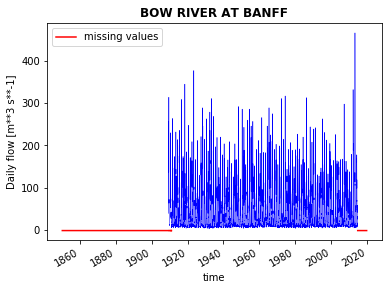

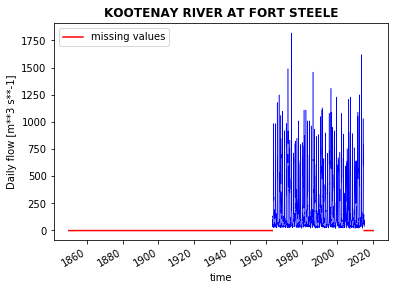

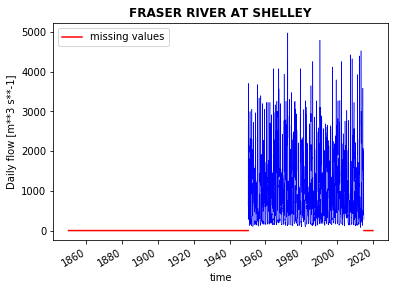

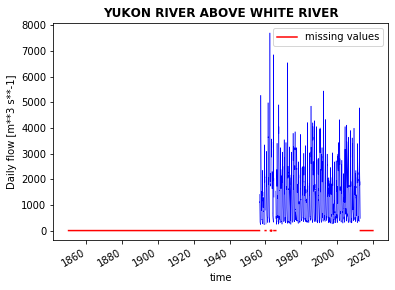

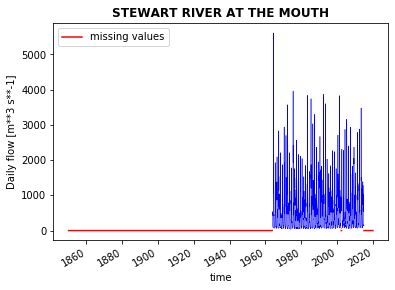

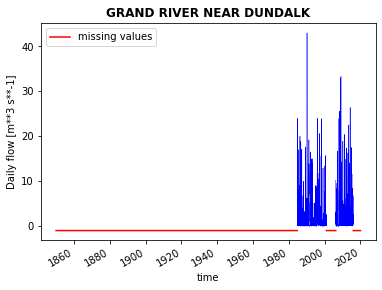

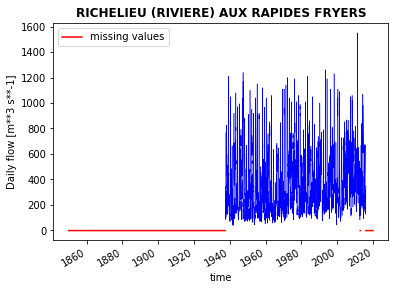

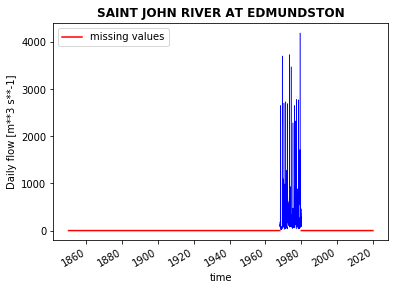

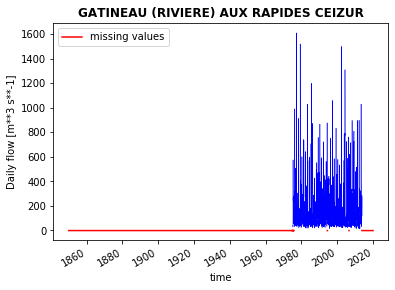

In [20]:
# Plot stations daily Q data
for b in range(len(basinno)):
    plt.subplots()
    stationsq_da.sel(Station_ID=basinno[b]).plot(lw=.5, color='b')
    missingvalues = stationsq_da.fillna(-1)
    missingvalues = missingvalues.where(missingvalues==-1)
    missingvalues.sel(Station_ID=basinno[b]).plot(color='r', label='missing values')
    plt.title(stationsq_da.Station_Name.data[b], fontweight='bold')
    plt.legend()

## Flow regimes: Plot mean flow annual hydrographs

In [5]:
# Define the time period that will be used to calculate the flow totals
startmonth, startday, endmonth, endday = 5, 16, 9, 30

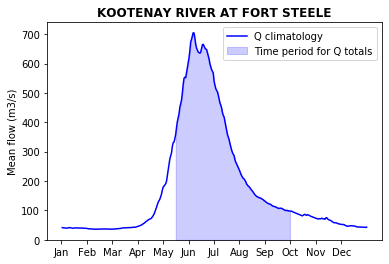

In [13]:
# Day of year averages
# for b in range(len(basinno)):
for b in range(1,2):
    plt.subplots()
    stationsq_climatology = stationsq_da.sel(Station_ID=basinno[b]).groupby("time.dayofyear").mean(skipna=True)
    clim_plot, = stationsq_climatology.plot(color='b', label='Q climatology')
    plt.title(stationsq_da.Station_Name.data[b], fontweight='bold')
    plt.ylabel('Mean flow ['+stationsq_da.attrs['units']+']')
    plt.xticks(np.linspace(0,366,13)[:-1], ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'))
    
    # To visualize a time period to be used for Q totals for regression
    starttimeofyear = datetime.date(2020,startmonth, startday).timetuple().tm_yday
    endtimeofyear = datetime.date(2020,endmonth, endday).timetuple().tm_yday
    processing_timeofyear = np.arange(starttimeofyear,endtimeofyear+1)
    plt.fill_between(processing_timeofyear, [0]*len(processing_timeofyear), stationsq_climatology.sel(dayofyear=processing_timeofyear), color='b', alpha=.2)
    patch = [clim_plot, mpatches.Patch(color='b', alpha=.2, label='Time period for Q totals')]
    plt.legend(handles=patch)
    plt.ylabel('Mean flow (m3/s)')
    plt.xlabel('')
    plt.ylim(bottom=0);

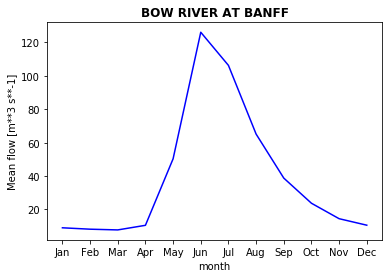

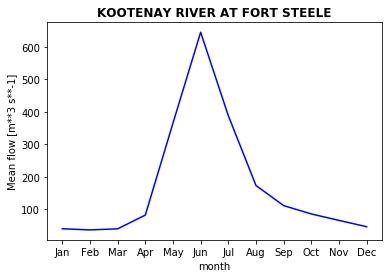

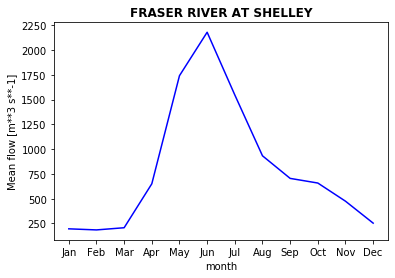

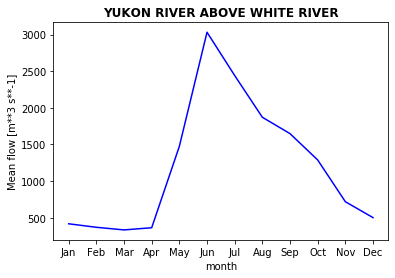

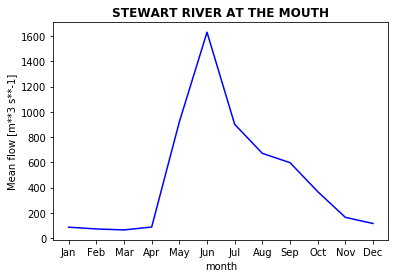

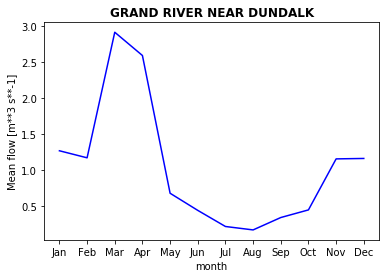

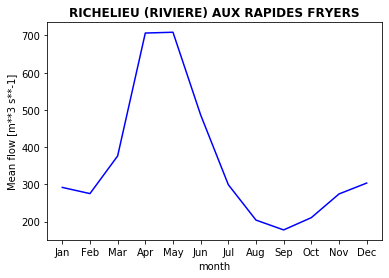

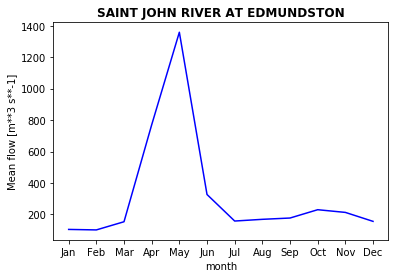

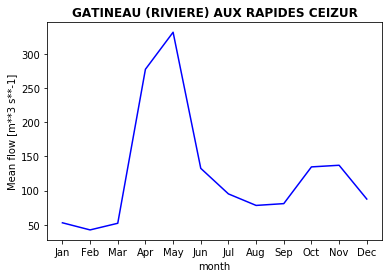

In [74]:
# Month of year averages - for smoother hydrographs
for b in range(len(basinno)):
    plt.subplots()
    stationsq_climatology = stationsq_da.sel(Station_ID=basinno[b]).groupby("time.month").mean(skipna=True)
    stationsq_climatology.plot(color='b')
    plt.title(stationsq_da.Station_Name.data[b], fontweight='bold')
    plt.ylabel('Mean flow ['+stationsq_da.attrs['units']+']')
    plt.xticks(np.arange(1,13), ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'))

## Calculate Q totals

### For several months aggregations

In [21]:
# Defining forecast period for which to calculate Q totals
# Note: This code assumes that fc period doesn't overlap 2 different years
startdate = date(2010, startmonth, startday) #2010 is a common year so that it works if fc period includes Feb
enddate = date(2010, endmonth, endday)
delta = enddate-startdate
fcperioddays = delta.days+1
startmonth_datetime_object = datetime.datetime.strptime(str(startmonth), "%m")
endmonth_datetime_object = datetime.datetime.strptime(str(endmonth), "%m")
startmonth_name, endmonth_name = startmonth_datetime_object.strftime("%b"), endmonth_datetime_object.strftime("%b")

# Calculating stations' forecast period Q totals for all years and display new DataArray
#Note: Totals calculated for periods with no missing data. Otherwise, could apply other min_count threshold and interpolate for missing values
if startmonth != endmonth:
    stationsq_fcaggreg_da = stationsq_da.sel(time=( ((stationsq_da['time.month'] == startmonth) & (stationsq_da['time.day'] >= startday)) | ((stationsq_da['time.month'] > startmonth) & (stationsq_da['time.month'] < endmonth)) | ((stationsq_da['time.month'] == endmonth) & (stationsq_da['time.day'] <= endday)) ))
else:
    stationsq_fcaggreg_da = stationsq_da.sel(time=( (stationsq_da['time.month'] == startmonth) & (stationsq_da['time.day'] >= startday) & (stationsq_da['time.day'] <= endday)) )
stationsq_fcaggreg_da = stationsq_fcperiod_da.groupby("time.year").sum("time",min_count=fcperioddays)
stationsq_fcaggreg_da.attrs['long_name'] = 'Flow totals'
stationsq_fcaggreg_da.attrs['info'] = 'Calculated over time period:'+str(startday)+startmonth_name+'-'+str(endday)+endmonth_name
stationsq_fcaggreg_da.attrs['units'] = 'm**3 s**-1'
stationsq_fcaggreg_da = stationsq_fcaggreg_da.rename('Qtot')

display(stationsq_fcaggreg_da)

#Future: Interpolate missing data within timeseries?

<xarray.DataArray 'Qtot' (Station_ID: 9, year: 170)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    lat           (Station_ID) float64 51.17 49.61 54.0 ... 45.4 47.36 47.08
    lon           (Station_ID) float64 -115.6 -115.6 -122.6 ... -68.32 -75.75
  * Station_ID    (Station_ID) object '05BB001' '08NG065' ... '02LG005'
    Station_Name  (Station_ID) object 'BOW RIVER AT BANFF' ... 'GATINEAU (RIVIERE) AUX RAPIDES CEIZUR'
  * year          (year) int64 1850 1851 1852 1853 1854 ... 2016 2017 2018 2019
Attributes:
    long_name:  Flow totals
    info:       Calculated over time period:16May-30Sep
    units:      m**3 s**-1

### For monthly aggregations

In [41]:
# Monthly averages for months without NA
stationsq_fcaggreg_da = stationsq_da.resample(time='1MS').mean(skipna=False)

# Adding information to the DataArray
stationsq_fcaggreg_da.attrs['long_name'] = 'Monthly flow averages'
stationsq_fcaggreg_da.attrs['info'] = 'Calculated for months without missing data' 
stationsq_fcaggreg_da.attrs['units'] = 'm**3 s**-1'
stationsq_fcaggreg_da = stationsq_fcaggreg_da.rename('Qmean')

display(stationsq_fcaggreg_da)

<xarray.DataArray 'Qmean' (Station_ID: 9, time: 2041)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * time          (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2020-01-01
    lat           (Station_ID) float64 51.17 49.61 54.0 ... 45.4 47.36 47.08
    lon           (Station_ID) float64 -115.6 -115.6 -122.6 ... -68.32 -75.75
  * Station_ID    (Station_ID) object '05BB001' '08NG065' ... '02LG005'
    Station_Name  (Station_ID) object 'BOW RIVER AT BANFF' ... 'GATINEAU (RIVIERE) AUX RAPIDES CEIZUR'
Attributes:
    long_name:  Monthly flow averages
    info:       Calculated for months without missing data
    units:      m**3 s**-1

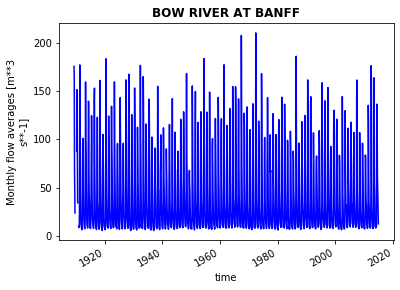

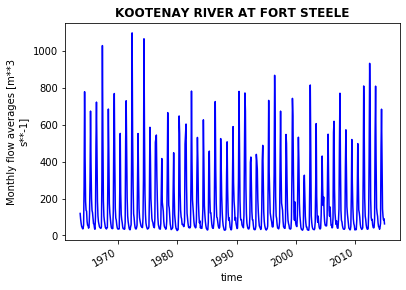

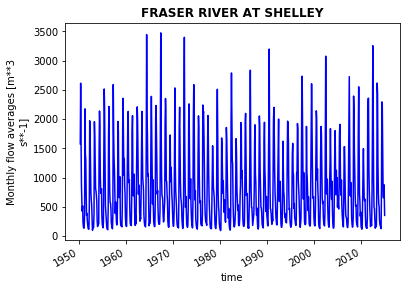

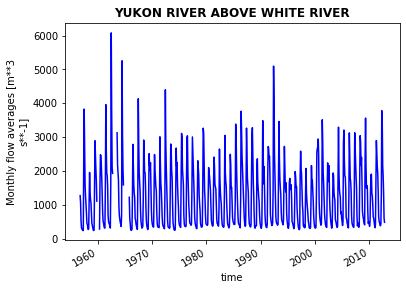

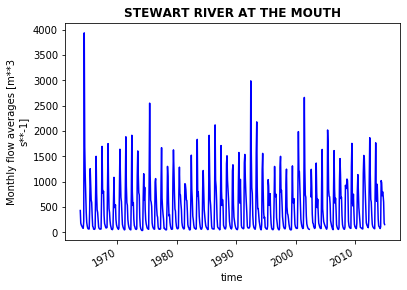

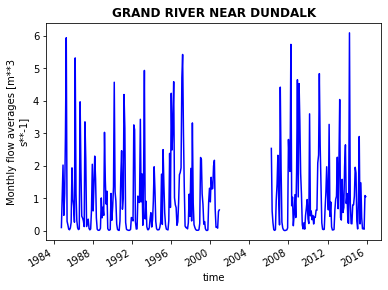

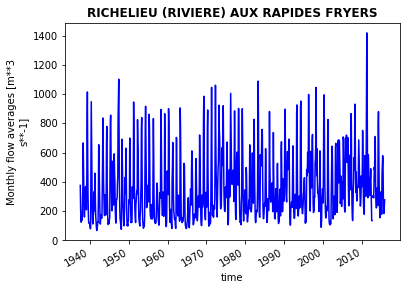

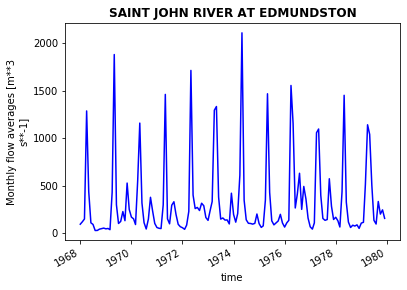

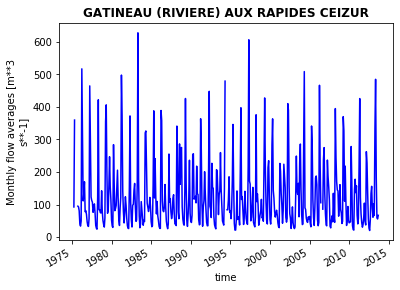

In [42]:
# Plot stations Q totals
for b in range(len(basinno)):
    plt.subplots()
    stationsq_fcaggreg_da.sel(Station_ID=basinno[b]).plot(color='b')
    plt.title(stationsq_da.Station_Name.data[b], fontweight='bold');

## Test if data normally distributed

BOW RIVER AT BANFF: The null hypothesis cannot be rejected, the data is normally distributed
KOOTENAY RIVER AT FORT STEELE: The null hypothesis cannot be rejected, the data is normally distributed
FRASER RIVER AT SHELLEY: The null hypothesis cannot be rejected, the data is normally distributed
YUKON RIVER ABOVE WHITE RIVER: The null hypothesis cannot be rejected, the data is normally distributed
STEWART RIVER AT THE MOUTH: The null hypothesis cannot be rejected, the data is normally distributed
GRAND RIVER NEAR DUNDALK: The null hypothesis cannot be rejected, the data is normally distributed
RICHELIEU (RIVIERE) AUX RAPIDES FRYERS: The null hypothesis cannot be rejected, the data is normally distributed
SAINT JOHN RIVER AT EDMUNDSTON: The null hypothesis cannot be rejected, the data is normally distributed
GATINEAU (RIVIERE) AUX RAPIDES CEIZUR: The null hypothesis cannot be rejected, the data is normally distributed


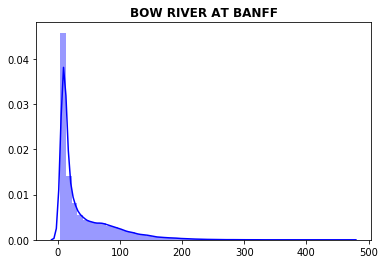

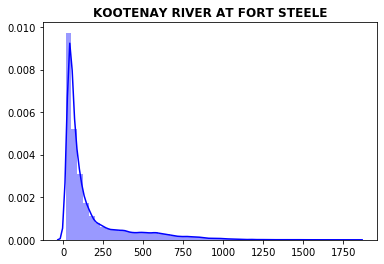

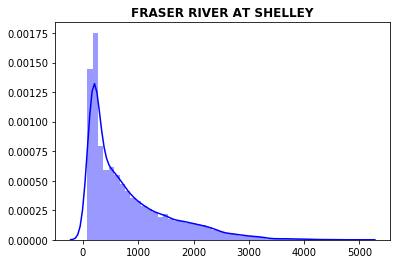

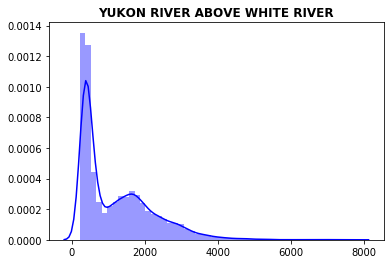

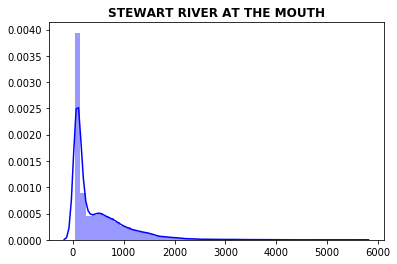

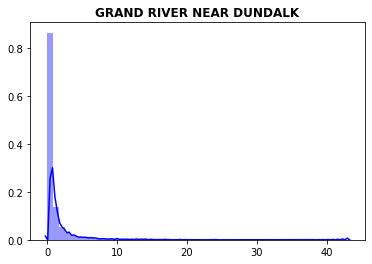

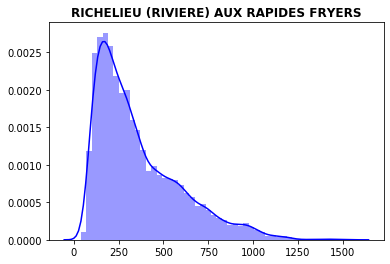

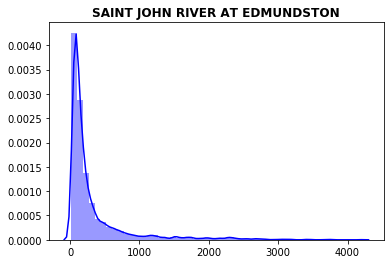

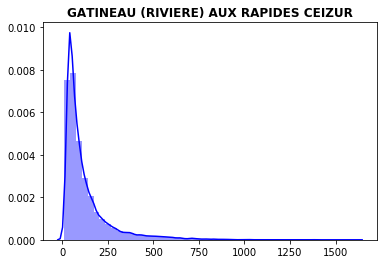

In [43]:
# Running a test to check if stations daily Q data normally distributed, plotting data distribution & saving results to list
stationsq_normdistrib = []
for b in range(len(basinno)):
    k2, p = stats.normaltest(stationsq_da.sel(Station_ID=basinno[b]).data)
    if p < 1e-3:  # null hypothesis: normal distribution
        print(stationsq_da.Station_Name.data[b]+": The null hypothesis can be rejected, the data is not normally distributed")
        stationsq_normdistrib += ['no']
    else:
        print(stationsq_da.Station_Name.data[b]+": The null hypothesis cannot be rejected, the data is normally distributed")
        stationsq_normdistrib += ['yes']
    plt.subplots()
    sns.distplot(stationsq_da.sel(Station_ID=basinno[b]).data, color='b')
    plt.title(stationsq_da.Station_Name.data[b], fontweight='bold');

In [44]:
# Store data for use in other Notebooks
%store stationsq_fcaggreg_da
%store stationsq_normdistrib

Stored 'stationsq_fcaggreg_da' (DataArray)
Stored 'stationsq_normdistrib' (list)
